In [1]:
import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

#statistics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings("ignore")

## I. Introduction

For this project, we will analyze two datasets: Retail Sales: Used Car Dealers and Retail Sales: New Car Dealers. The two datasets represent the monthly retail sales of used and new car dealerships, measured in millions of dollars and not seasonally adjusted. The time frame for our analysis spans from January 2000 to January 2023. By examining these datasets, we aim to understand the patterns, trends, and cycles in the sales of both used and new cars over the past two decades. Additionally, we will fit a VAR (Vector Autoregression) model to explore the relationship and dynamics between the two variables. This project will provide insights into the automotive industry, consumer preferences, and economic factors influencing the sales of used and new cars.

## II. Results

### (a) Time Series Plot

In [2]:
used = pd.read_excel("used_car.xls", header=0)
used

,date,sales(millions)
0,2000-01-01,4381
1,2000-02-01,5327
2,2000-03-01,5434
3,2000-04-01,4841
4,2000-05-01,4986
...,...,...
274,2022-11-01,11973
275,2022-12-01,11219
276,2023-01-01,12570
277,2023-02-01,14100


In [3]:
new = pd.read_csv("new_car.csv", header=0)
new

,DATE,sales
0,1/1/2000,47032
1,2/1/2000,53501
2,3/1/2000,59381
3,4/1/2000,51683
4,5/1/2000,57481
...,...,...
274,11/1/2022,88870
275,12/1/2022,95313
276,1/1/2023,89104
277,2/1/2023,87828


In [4]:
# convert 'date' column to datetime format and set as index
used['date'] = pd.to_datetime(used['date'])
used.set_index('date', inplace=True)
new['date'] = pd.to_datetime(new['DATE'])
new.set_index('date', inplace=True)

In [5]:
used = used.rename(columns={'sales(millions)': 'sales'})
new = new.rename(columns={'sales(millions)': 'sales'})

In [6]:
used.head()

,sales
date,
2000-01-01,4381
2000-02-01,5327
2000-03-01,5434
2000-04-01,4841
2000-05-01,4986


In [7]:
new.head()

,DATE,sales
date,,
2000-01-01,1/1/2000,47032
2000-02-01,2/1/2000,53501
2000-03-01,3/1/2000,59381
2000-04-01,4/1/2000,51683
2000-05-01,5/1/2000,57481


#### New Car Sales Time Series Plot

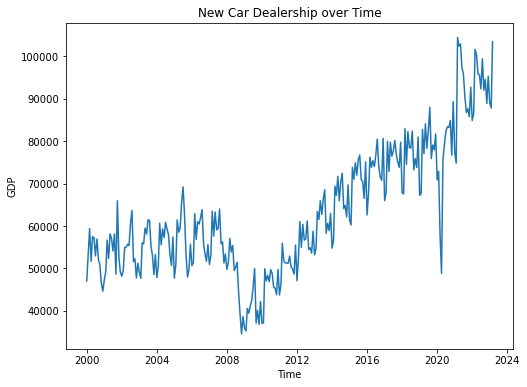

In [8]:
plt.figure(figsize=(8,6))
plt.plot(new['sales'])
plt.xlabel('Time')
plt.ylabel('GDP')
plt.title('New Car Dealership over Time')
plt.show()

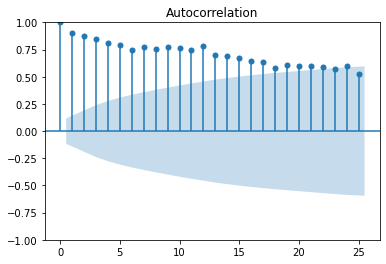

In [9]:
plot_acf(new['sales']);

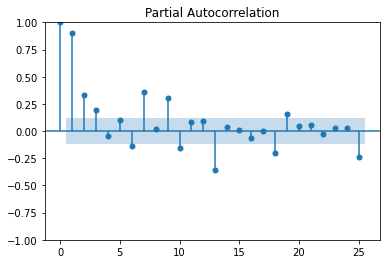

In [10]:
plot_pacf(new['sales']);

In [11]:
# ADF Test for Stationarity
adf = adfuller(new["sales"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.9823354006736892 , Series is Non-Stationary


#### Used Car Sales Time Series Plot

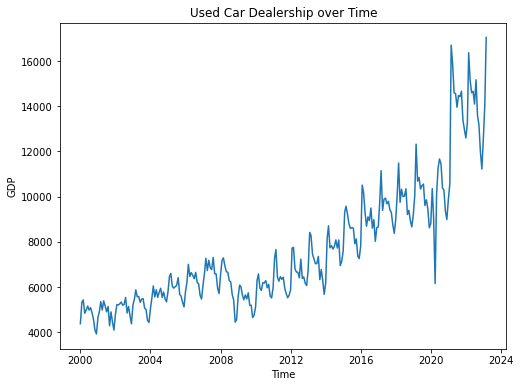

In [12]:
plt.figure(figsize=(8,6))
plt.plot(used['sales'])
plt.xlabel('Time')
plt.ylabel('GDP')
plt.title('Used Car Dealership over Time')
plt.show()

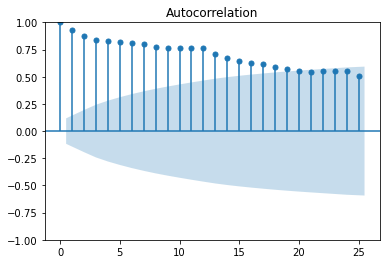

In [13]:
plot_acf(used['sales']);

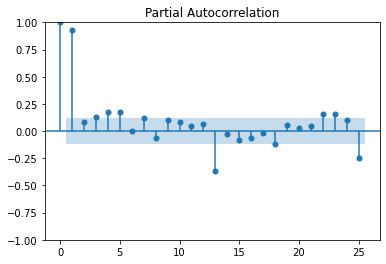

In [14]:
plot_pacf(used['sales']);

In [15]:
# ADF Test for Stationarity
adf = adfuller(used["sales"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.9861535349637951 , Series is Non-Stationary


### (b) STL Decomposition

#### New Car Sales Data

Text(0.5, 0.98, 'Additive Decomposition')

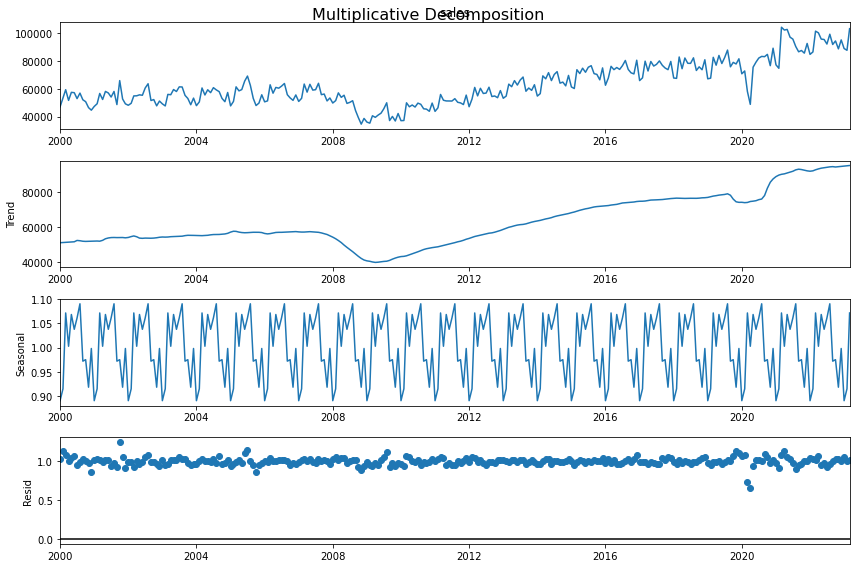

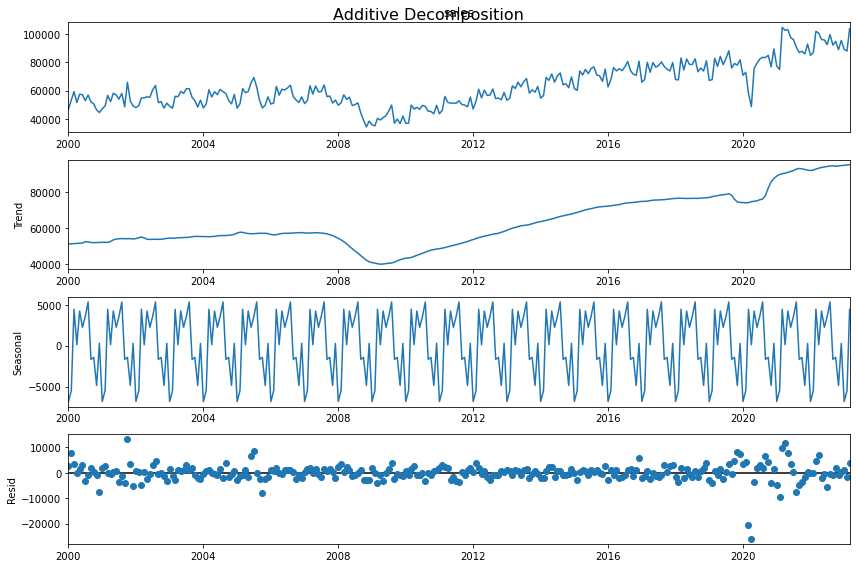

In [16]:
# Multiplicative Decomposition
decomposeM = seasonal_decompose(new["sales"],model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeM.plot();
decomposeM.plot().suptitle('Multiplicative Decomposition', fontsize=16)

# Additive Decomposition
decomposeA = seasonal_decompose(new["sales"],model='additive', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeA.plot();
decomposeA.plot().suptitle('Additive Decomposition', fontsize=16)

In [17]:
ljung_result = ljung(x=decomposeM.resid.dropna())
ljung_result

,lb_stat,lb_pvalue
1,33.212213,8.262991e-09
2,33.805630,4.562476e-08
3,38.408449,2.316115e-08
4,56.871138,1.316624e-11
5,82.746544,2.233100e-16
6,93.732959,5.074217e-18
7,94.877983,1.228199e-17
8,94.973625,4.529188e-17
9,100.216650,1.422488e-17
10,100.958775,3.502764e-17


In [18]:
ljung_p = np.mean(ljung(x=decomposeA.resid.dropna())['lb_pvalue'])
ljung_p = round(ljung_p, 3)
print("Ljung Box (A), p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box (A), p value: 0.0 , Residuals are correlated


Since the amplitude of the seasonality of new car sales seems to be constant, a additive seasonality should be more appropriate.
The time series has an overall increasing trend, with a decrease around 2008-2009 during financial crisis. The data has clear seasonality.
From the Ljung Box test we could see the residuals are correlated, suggesting there are still dynamics left in the data not captured by seasonality and trend.

#### Used Car Sales Data

Text(0.5, 0.98, 'Additive Decomposition')

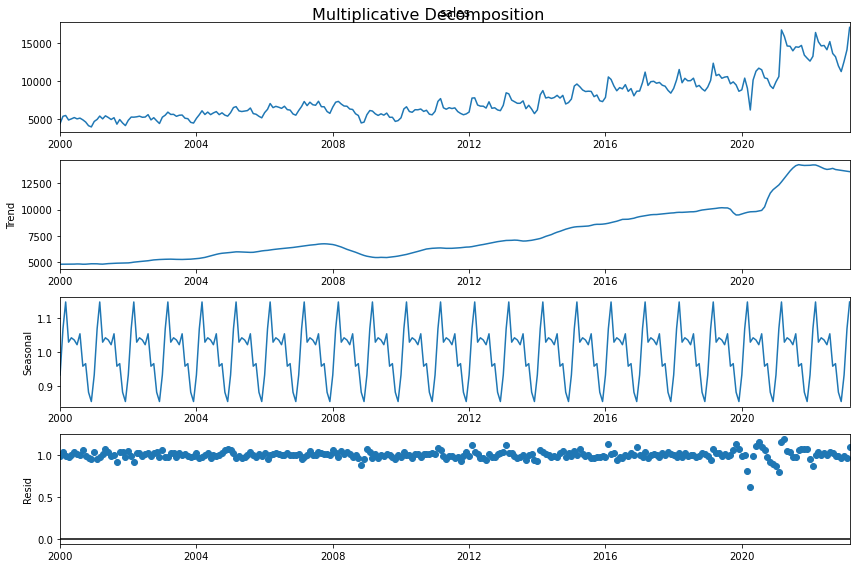

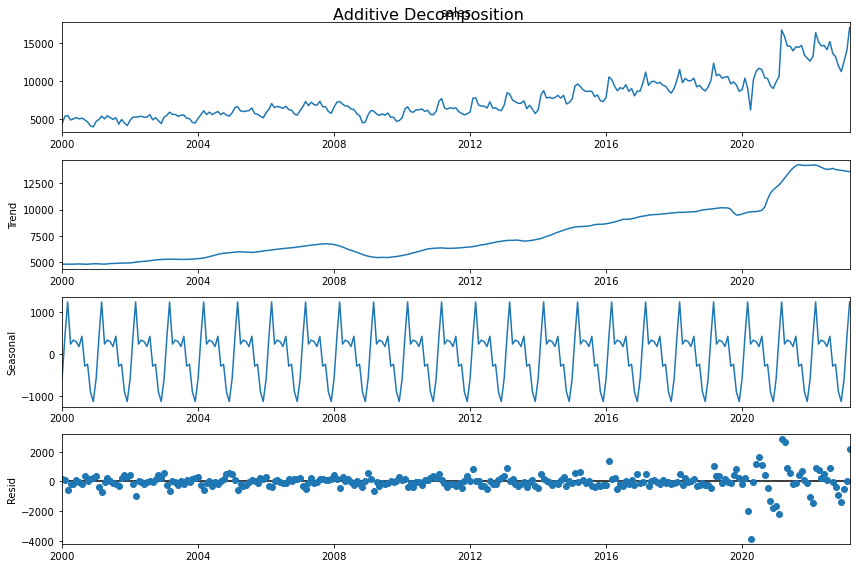

In [19]:
# Multiplicative Decomposition
decomposeM = seasonal_decompose(used["sales"],model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeM.plot();
decomposeM.plot().suptitle('Multiplicative Decomposition', fontsize=16)

# Additive Decomposition
decomposeA = seasonal_decompose(used["sales"],model='additive', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeA.plot();
decomposeA.plot().suptitle('Additive Decomposition', fontsize=16)

In [20]:
ljung_p = np.mean(ljung(x=decomposeA.resid.dropna())['lb_pvalue'])
ljung_p = round(ljung_p, 3)
print("Ljung Box (A), p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box (A), p value: 0.0 , Residuals are correlated


Since the amplitude of the seasonality of new car sales seems to be constant, a additive seasonality should be more appropriate. The time series has an overall increasing trend, with a decrease around 2008-2009 during financial crisis, and a higher than normal increase in 2021-2022. The data has clear seasonality. From the Ljung Box test we could see the residuals are correlated, suggesting there are still dynamics left in the data not captured by seasonality and trend.

### (c) Fitting Model

#### Used Car Model

In [21]:
## modeling seasonality
used['month'] = used.index.month_name()
## trend
used['t'] = np.arange(1,len(used)+1)
## cycle
used['year'] = used.index.strftime("%Y")

In [22]:
uresults = smf.ols('sales ~  t + I(t**2) + month + year', data = used).fit()
uresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     144.3
Date:                Fri, 19 May 2023   Prob (F-statistic):          1.11e-142
Time:                        12:49:14   Log-Likelihood:                -2176.1
No. Observations:                 279   AIC:                             4424.
Df Residuals:                     243   BIC:                             4555.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           4940.0481    249.152     19.827      0.000    4449.274    5430.822
month[T.August]      193.2802    187.113      1.033      0.303    -175.291     561.851
month[T.December]  -1317.0808    189.236     -6.960      0.000   -1689.832    -944.329
month[T.February]    158.2360    185.330      0.854      0.394    -206.823     523.295
month[T.January]    -860.6920    185.504     -4.640      0.000   -1226.093    -495.291
month[T.July]        -51.3778    186.843     -0.275      0.784    -419.417     316.661
month[T.June]         60.5300    186.661      0.324      0.746    -307.150     428.210
month[T.March]       961.7443    185.238      5.192      0.000     596.867    1326.622
month[T.May]          97.0908    186.559      0.520      0.603    -270.389     464.570
month[T.November]  -1095.3937    188.532     -5.810      0.000   -1466.760    -724.028
month[T.October]    -450.4886    187.949     -2.397      0.017    -820.707     -80.271
month[T.September]  -502.1045    187.479     -2.678      0.008    -871.396    -132.813
year[T.2001]        -140.5521    299.741     -0.469      0.640    -730.973     449.869
year[T.2002]        -122.1941    393.757     -0.310      0.757    -897.806     653.418
year[T.2003]        -160.2593    494.891     -0.324      0.746   -1135.084     814.565
year[T.2004]         -16.2477    586.923     -0.028      0.978   -1172.353    1139.858
year[T.2005]          43.4240    664.173      0.065      0.948   -1264.848    1351.695
year[T.2006]         128.0891    724.323      0.177      0.860   -1298.664    1554.843
year[T.2007]         239.3311    766.290      0.312      0.755   -1270.087    1748.750
year[T.2008]        -520.5168    789.523     -0.659      0.510   -2075.699    1034.665
year[T.2009]       -1517.5380    793.737     -1.912      0.057   -3081.022      45.946
year[T.2010]       -1297.2323    778.806     -1.666      0.097   -2831.304     236.840
year[T.2011]       -1278.1832    744.722     -1.716      0.087   -2745.117     188.750
year[T.2012]       -1229.8073    691.609     -1.778      0.077   -2592.121     132.506
year[T.2013]       -1197.4379    619.798     -1.932      0.055   -2418.301      23.425
year[T.2014]        -934.3251    530.047     -1.763      0.079   -1978.398     109.748
year[T.2015]        -553.8021    424.222     -1.305      0.193   -1389.424     281.820
year[T.2016]        -325.1191    307.929     -1.056      0.292    -931.669     281.431
year[T.2017]        -231.1925    203.784     -1.135      0.258    -632.600     170.215
year[T.2018]        -368.9392    196.170     -1.881      0.061    -755.349      17.471
year[T.2019]        -387.7758    326.288     -1.188      0.236   -1030.489     254.938
year[T.2020]       -1162.6189    518.300     -2.243      0.026   -2183.554    -141.684
year[T.2021]        2410.1981    741.9

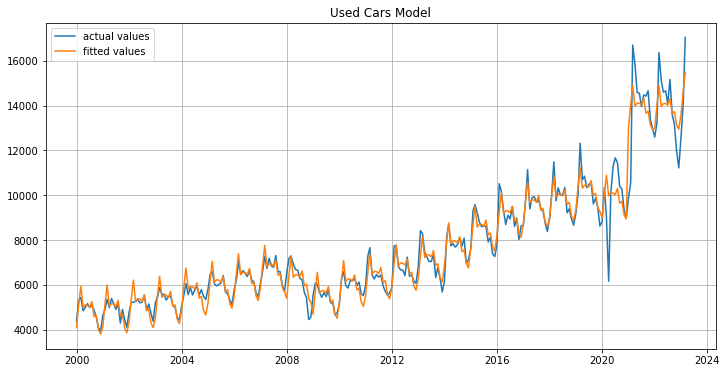

In [23]:
plt.figure(figsize = (12,6))
plt.title('Used Cars Model')
plt.plot(used.sales, label='actual values')
plt.plot(uresults.fittedvalues, label = 'fitted values')
plt.legend()
plt.grid()

This model adds seasonal component by using month dummy and trend component by using period dummy. There is a yearly cycle accordingto PACF plot, so a year dummy variable is also used. The R-square of the model is 95.4%. According to the actual value vs fitted value plot, the model captures the time seires data well.

#### New Car Model

In [24]:
## modeling seasonality
new['month'] = new.index.month_name()
## trend
new['t'] = np.arange(1,len(new)+1)
## cycle
new['year'] = used.index.strftime("%Y")

In [25]:
nresults = smf.ols('sales ~  t + I(t**2) + month + year', data = new).fit()
nresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     114.3
Date:                Fri, 19 May 2023   Prob (F-statistic):          4.25e-131
Time:                        12:49:14   Log-Likelihood:                -2683.5
No. Observations:                 279   AIC:                             5439.
Df Residuals:                     243   BIC:                             5570.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           5.504e+04   1535.758     35.837      0.000     5.2e+04    5.81e+04
month[T.August]     5055.7409   1153.354      4.384      0.000    2783.894    7327.587
month[T.December]   -325.7626   1166.436     -0.279      0.780   -2623.379    1971.853
month[T.February]  -5565.2640   1142.364     -4.872      0.000   -7815.463   -3315.065
month[T.January]   -6847.6382   1143.436     -5.989      0.000   -9099.949   -4595.328
month[T.July]       3369.7307   1151.689      2.926      0.004    1101.162    5638.299
month[T.June]       2048.3140   1150.568      1.780      0.076    -218.044    4314.672
month[T.March]      4317.5878   1141.797      3.781      0.000    2068.506    6566.669
month[T.May]        4080.7516   1149.939      3.549      0.000    1815.631    6345.872
month[T.November]  -5389.0160   1162.100     -4.637      0.000   -7678.091   -3099.941
month[T.October]   -1882.1543   1158.508     -1.625      0.106   -4164.154     399.846
month[T.September] -2056.1773   1155.610     -1.779      0.076   -4332.468     220.113
year[T.2001]        5360.8080   1847.582      2.902      0.004    1721.489    9000.127
year[T.2002]        8206.3735   2427.091      3.381      0.001    3425.551     1.3e+04
year[T.2003]        1.187e+04   3050.478      3.892      0.000    5864.942    1.79e+04
year[T.2004]        1.476e+04   3617.754      4.081      0.000    7636.784    2.19e+04
year[T.2005]        1.705e+04   4093.922      4.165      0.000    8988.679    2.51e+04
year[T.2006]         1.81e+04   4464.683      4.053      0.000    9301.709    2.69e+04
year[T.2007]         1.84e+04   4723.363      3.896      0.000    9099.770    2.77e+04
year[T.2008]        8591.5063   4866.570      1.765      0.079    -994.538    1.82e+04
year[T.2009]          99.8740   4892.547      0.020      0.984   -9537.340    9737.088
year[T.2010]        3666.3325   4800.510      0.764      0.446   -5789.589    1.31e+04
year[T.2011]        6330.1318   4590.416      1.379      0.169   -2711.952    1.54e+04
year[T.2012]        8761.2719   4263.032      2.055      0.041     364.060    1.72e+04
year[T.2013]        1.067e+04   3820.397      2.792      0.006    3140.432    1.82e+04
year[T.2014]        1.091e+04   3267.175      3.339      0.001    4472.726    1.73e+04
year[T.2015]        1.117e+04   2614.877      4.273      0.000    6022.685    1.63e+04
year[T.2016]        8838.7402   1898.052      4.657      0.000    5100.005    1.26e+04
year[T.2017]        4795.5843   1256.109      3.818      0.000    2321.333    7269.836
year[T.2018]        -719.5642   1209.178     -0.595      0.552   -3101.371    1662.243
year[T.2019]       -5821.4552   2011.218     -2.894      0.004   -9783.101   -1859.809
year[T.2020]       -1.661e+04   3194.771     -5.200      0.000   -2.29e+04   -1.03e+04
year[T.2021]       -8818.0482   4573.5

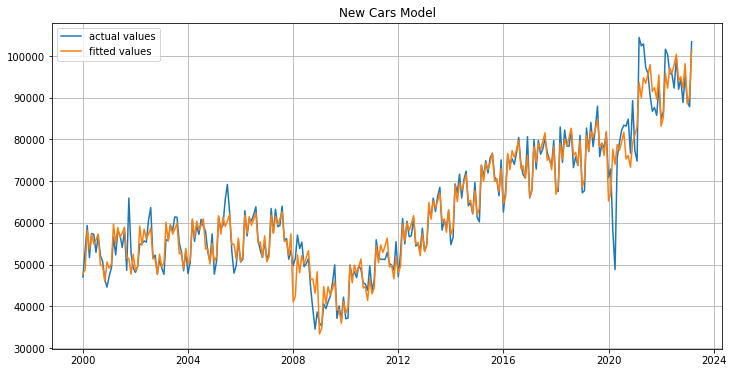

In [26]:
plt.figure(figsize = (12,6))
plt.title('New Cars Model')
plt.plot(new.sales, label='actual values')
plt.plot(nresults.fittedvalues, label = 'fitted values')
plt.legend()
plt.grid()

Same as used car model, this model adds seasonal component by using month dummy and trend component by using period dummy. There is a yearly cycle accordingto PACF plot, so a year dummy variable is also used. The R-square of the model is 94.3%. According to the actual value vs fitted value plot, the model captures the time seires data well.

### (e) Residuals vs. Fitted values

Text(0, 0.5, 'Residuals')

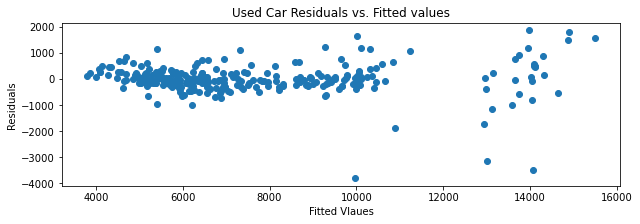

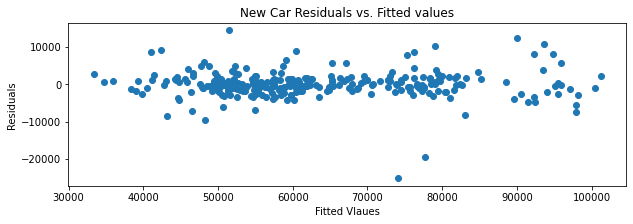

In [27]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.title('Used Car Residuals vs. Fitted values')
plt.scatter(uresults.fittedvalues,uresults.resid)
plt.xlabel('Fitted Vlaues')
plt.ylabel('Residuals')

fig, ax = plt.subplots(figsize=(10, 3))
plt.title('New Car Residuals vs. Fitted values')
plt.scatter(nresults.fittedvalues,nresults.resid)
plt.xlabel('Fitted Vlaues')
plt.ylabel('Residuals')

The fitted values for used car centered around 0 at the first 2/3 of the plot, indicating good model fits. However, residual flunctuation is larger at the end of the plot, and outliers are mostly negative residuals. This indicates bad model fits and exaggerated predictions at larger values. There is possibility of heteroskedasticity.<br> The fitted values vs residuals plot for new car performs has the same but slighter problem comparing to used car. This indicates that new car sales data fits the linearity assumption and the time series is easier to capture.

### (f) ACF and PACF of the respective residuals

#### Used Cars

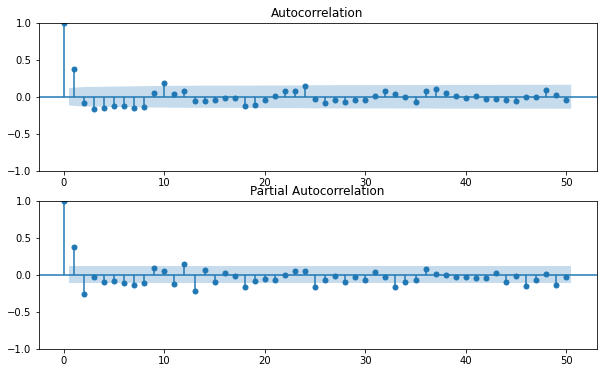

In [28]:
# Plot ACF and PACF of residuals for Used Cars
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(uresults.resid, lags=50, ax=axes[0])
plot_pacf(uresults.resid, lags=50, ax=axes[1])
plt.show()

The ACF plot for used cars residuals goes up and down and shows presence of a periodic or cyclical component in the residuals. This may indicate that the model is not capturing the seasonality or other repetitive patterns in the data. The PACF also shows significant correlations that are unique to 12 lags. The model may still have some room for improvement or further specification.

#### New Cars

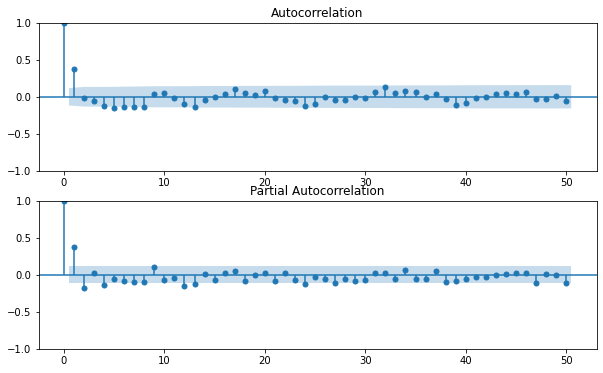

In [29]:
# Plot ACF and PACF of residuals for Used Cars
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(nresults.resid, lags=50, ax=axes[0])
plot_pacf(nresults.resid, lags=50, ax=axes[1])
plt.show()

Same as above, the ACF plot for unew cars residuals shows presence of a periodic or cyclical component in the residuals.  The PACF also shows correlations that are unique to 12 lags but it is not very significant. The model may still have some room for improvement or further specification.

### (g) Plot CUSUM

#### Used Cars

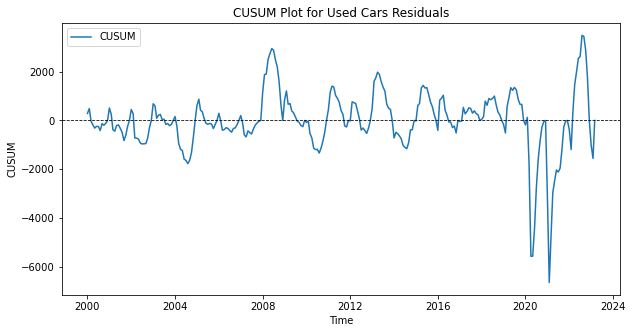

In [30]:
cumulative_sum = np.cumsum(uresults.resid)

# Plot CUSUM
plt.figure(figsize=(10,5))
plt.plot(cumulative_sum, label='CUSUM')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a horizontal line at 0
plt.xlabel('Time')
plt.ylabel('CUSUM')
plt.title('CUSUM Plot for Used Cars Residuals')
plt.legend()
plt.show()

1. The CUSUM line fluctuates around zero without a consistent upward or downward trend, it suggests that the residuals are randomly distributed and exhibit no significant shifts or deviations.
2. A negative deviation from 0 is present during 2020 and 2021. This indicates that the residuals consistently fall behind the expected values. This is possibly because the pandemic give unexpected flunctuation to the market. 
3. There are Larger deviations during 2008 and between 2020 and 2023, indicating more substantial shifts or changes in the residuals, suggesting potential problems in the model's performance.

#### New Cars

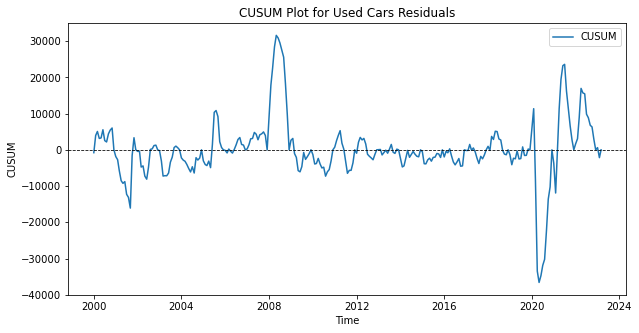

In [31]:
cumulative_sum = np.cumsum(nresults.resid)

# Plot CUSUM
plt.figure(figsize=(10,5))
plt.plot(cumulative_sum, label='CUSUM')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a horizontal line at 0
plt.xlabel('Time')
plt.ylabel('CUSUM')
plt.title('CUSUM Plot for Used Cars Residuals')
plt.legend()
plt.show()

1. The CUSUM line fluctuates around zero and performance better than used car data.
2. A negative deviation from 0 is present during 2020 and 2021. This indicates that the residuals consistently fall behind the expected values. There is a huge positive diviation during 2008, indicating higher residual values.
3. There are Larger deviations during 2008 and between 2020 and 2023, indicating more substantial shifts or changes in the residuals, suggesting potential problems in the model's performance.

### (h) associated diagnostic

**Used Cars**   
**F-statistic**: The p-value for F-statistic is 1.11e-142, very close to 0. This suggest the model is overall significant.  
**Durbin-Watson statistic**: The Durbin-Watson statistic is 1.231. This indicates positive autocorrelation.  
**Jarque-Bera test**: The p-value for JB test is 0. This indicates that the redisuals do not follow a normal distribution. In fact, the distribution of residuals are left skewed. This is because of the outliers during the pandemic.  
  
**New Cars**  
**F-statistic**: The p-value for F-statistic is 4.25e-131, very close to 0. This suggest the model is overall significant.  
**Durbin-Watson statistic**: The Durbin-Watson statistic is 1.252. This indicates positive autocorrelation. There is still some seasonality that is not taken out of the model.  
**Jarque-Bera test**: The p-value for JB test is 0. Same as the used car model, this indicates that the redisuals do not follow a normal distribution. In fact, the distribution of residuals are left skewed. This is because of the outliers during the pandemic.

### (i)  forecast 12-steps ahead

#### New Cars

In [32]:
forecast_data = new.copy()
forecast_data['t'] = forecast_data['t'] + 12

# Generate the forecast
forecast = nresults.get_prediction(forecast_data)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)  # Specify the desired confidence level for the error bands (e.g., 95%)

In [33]:
index = pd.date_range(start=new.index[12], periods=len(new), freq='M') 
forecast_data.index = index

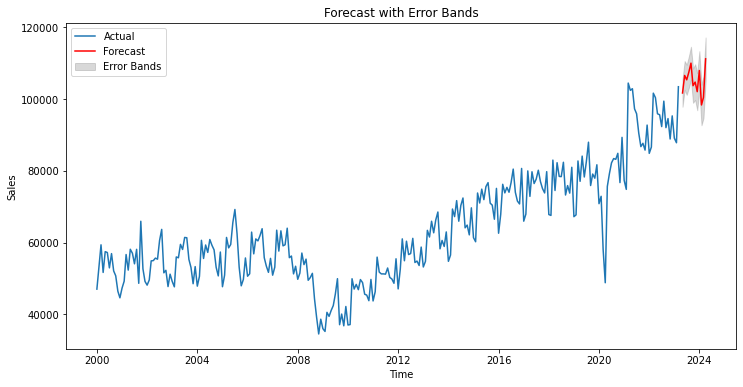

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(new.index, new['sales'], label='Actual')  # Plot the actual data
plt.plot(forecast_data.index[-12:], forecast_mean[-12:], label='Forecast', color='red')  # Plot the last 12 forecasted mean values
plt.fill_between(forecast_data.index[-12:], forecast_ci[-12:, 0], forecast_ci[-12:, 1], color='gray', alpha=0.3, label='Error Bands')  # Plot the last 12 error bands
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Forecast with Error Bands')
plt.legend()
plt.show()

#### Used Cars

In [35]:
forecast_data = used.copy()
forecast_data['t'] = forecast_data['t'] + 12  # Shift the 't' values by 12 to forecast 12 steps ahead

# Generate the forecast
forecast = uresults.get_prediction(forecast_data)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)  # Specify the desired confidence level for the error bands (e.g., 95%)

In [36]:
index = pd.date_range(start=used.index[12], periods=len(used), freq='M') 
forecast_data.index = index

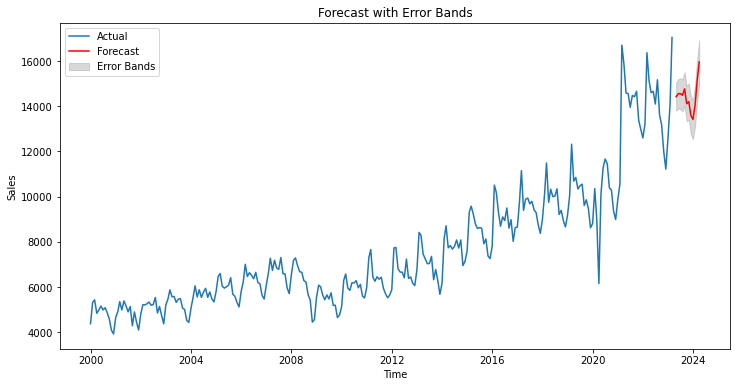

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(used.index, used['sales'], label='Actual')  # Plot the actual data
plt.plot(forecast_data.index[-12:], forecast_mean[-12:], label='Forecast', color='red')  # Plot the last 12 forecasted mean values
plt.fill_between(forecast_data.index[-12:], forecast_ci[-12:, 0], forecast_ci[-12:, 1], color='gray', alpha=0.3, label='Error Bands')  # Plot the last 12 error bands
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Forecast with Error Bands')
plt.legend()
plt.show()

### (j)  auto.arima, ets, and Holt-Winters models

In [38]:
used

,sales,month,t,year
date,,,,
2000-01-01,4381,January,1,2000
2000-02-01,5327,February,2,2000
2000-03-01,5434,March,3,2000
2000-04-01,4841,April,4,2000
2000-05-01,4986,May,5,2000
...,...,...,...,...
2022-11-01,11973,November,275,2022
2022-12-01,11219,December,276,2022
2023-01-01,12570,January,277,2023


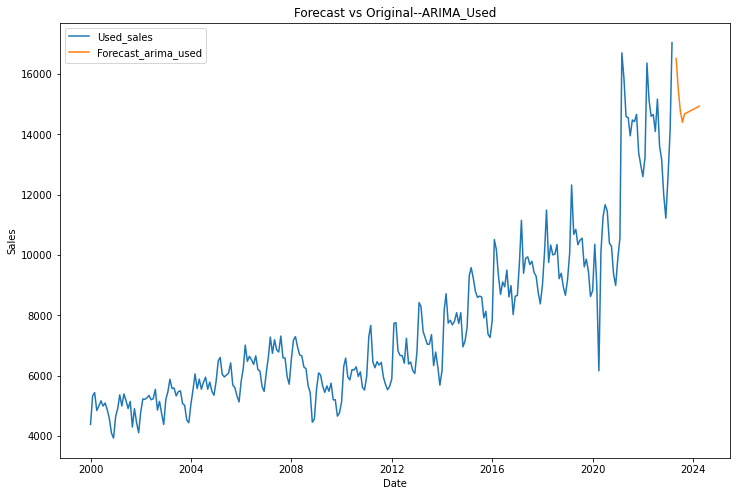

In [39]:
#auto.arima--Used
model = auto_arima(used['sales'], seasonal=True, suppress_warnings=True)
forecast_arima_used, confidence_interval = model.predict(n_periods=12, return_conf_int=True)

# Plotting the original "sales" data
plt.plot(used['sales'], label='Used_sales')

# Plotting the forecasted data
forecast_index = pd.date_range(start=used.index[-1], periods=len(forecast_arima_used)+1, freq='m')
plt.plot(forecast_index[1:], forecast_arima_used, label='Forecast_arima_used')

# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Original--ARIMA_Used')
plt.legend()
plt.show()

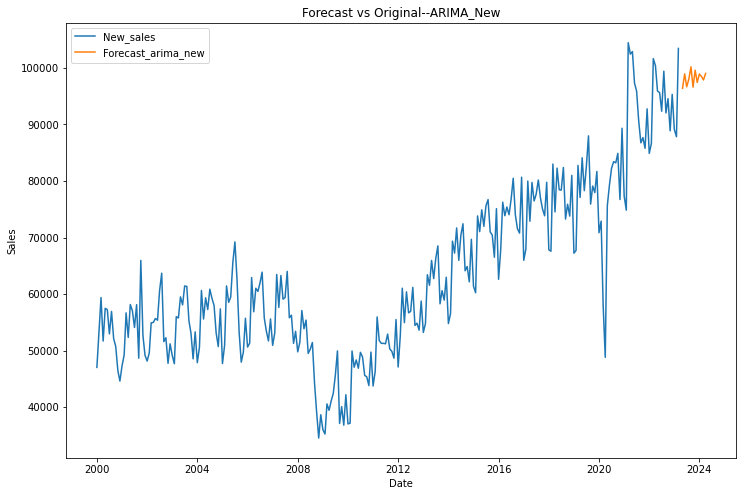

In [40]:
#auto.arima--New
model = auto_arima(new['sales'], seasonal=True, suppress_warnings=True)
forecast_arima_new, confidence_interval = model.predict(n_periods=12, return_conf_int=True)

# Plotting the original "sales" data
plt.plot(new['sales'], label='New_sales')

# Plotting the forecasted data
plt.plot(forecast_index[1:], forecast_arima_new, label='Forecast_arima_new')

# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Original--ARIMA_New')
plt.legend()
plt.show()

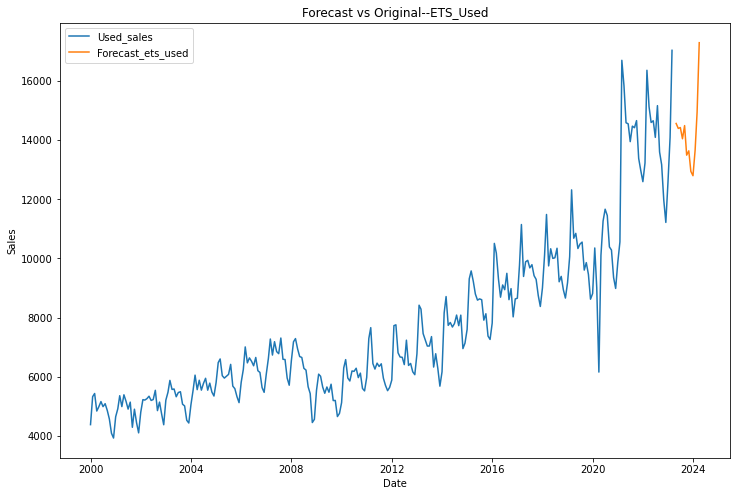

In [41]:
#ets--Used
model = sm.tsa.ExponentialSmoothing(used['sales'], trend='add', seasonal='add').fit()
forecast_ets_used = model.forecast(steps=12)

# Plotting the original "sales" data
plt.plot(used['sales'], label='Used_sales')

# Plotting the forecasted data
plt.plot(forecast_index[1:], forecast_ets_used, label='Forecast_ets_used')

# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Original--ETS_Used')
plt.legend()
plt.show()

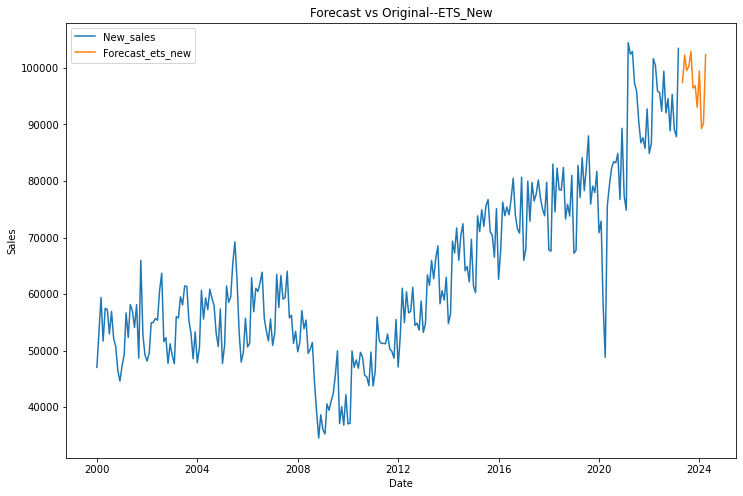

In [42]:
#ets--New
model = sm.tsa.ExponentialSmoothing(new['sales'], trend='add', seasonal='add').fit()
forecast_ets_new = model.forecast(steps=12)

# Plotting the original "sales" data
plt.plot(new['sales'], label='New_sales')

# Plotting the forecasted data
plt.plot(forecast_index[1:], forecast_ets_new, label='Forecast_ets_new')

# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Original--ETS_New')
plt.legend()
plt.show()

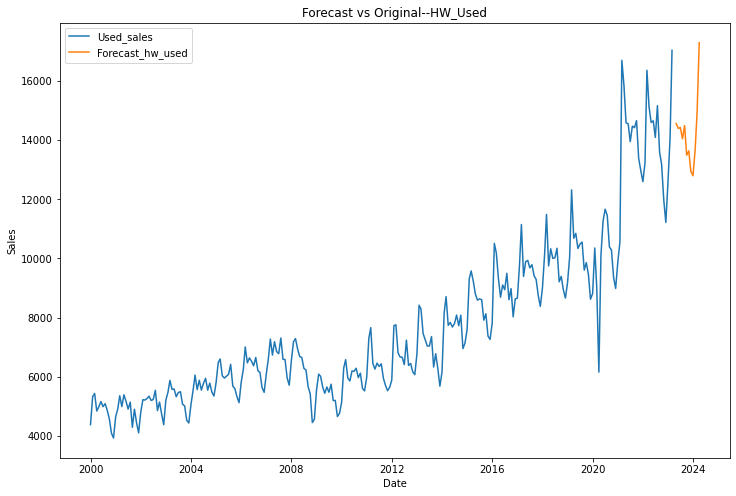

In [43]:
#Holt_Winters--Used
model = sm.tsa.ExponentialSmoothing(used['sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_hw_used = model.forecast(steps=12)

# Plotting the original "sales" data
plt.plot(used['sales'], label='Used_sales')

# Plotting the forecasted data
plt.plot(forecast_index[1:], forecast_hw_used, label='Forecast_hw_used')

# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Original--HW_Used')
plt.legend()
plt.show()

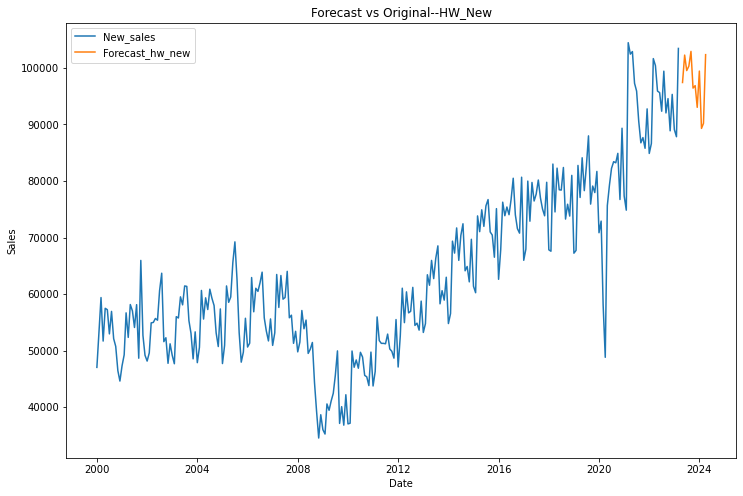

In [44]:
#Holt_Winters--New
model = sm.tsa.ExponentialSmoothing(new['sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_hw_new = model.forecast(steps=12)

# Plotting the original "sales" data
plt.plot(new['sales'], label='New_sales')

# Plotting the forecasted data
plt.plot(forecast_index[1:], forecast_hw_new, label='Forecast_hw_new')

# Adding labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecast vs Original--HW_New')
plt.legend()
plt.show()

In [45]:
#MAPE--Used
train_data = used[:-12]
test_data = used[-12:]

uresults = smf.ols('sales ~  t + I(t**2) + month + year', data = used).fit()
test_data['sales_pred'] = uresults.predict(test_data)
mape_ols = abs((test_data['sales'] - test_data['sales_pred']) / test_data['sales']).mean() * 100

model_arima = auto_arima(train_data['sales'], seasonal=True, suppress_warnings=True)
forecast_arima = model_arima.predict(n_periods=12)
mape_arima = np.mean(np.abs((test_data['sales'] - forecast_arima) / test_data['sales'])) * 100

model_ets = sm.tsa.ExponentialSmoothing(train_data['sales'], trend='add', seasonal='add').fit()
forecast_ets = model_ets.forecast(steps=12)
mape_ets = np.mean(np.abs((test_data['sales'] - forecast_ets) / test_data['sales'])) * 100

model_hw = sm.tsa.ExponentialSmoothing(train_data['sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_hw = model_hw.forecast(steps=12)
mape_hw = np.mean(np.abs((test_data['sales'] - forecast_hw) / test_data['sales'])) * 100

print('The MAPE for OLS model is',mape_ols)
print('The MAPE for ARIMA model is',mape_arima)
print('The MAPE for ETS model is',mape_ets)
print('The MAPE for Holt-Winters model is',mape_hw)

The MAPE for OLS model is 5.998719641238409
The MAPE for ARIMA model is 10.216665013665095
The MAPE for ETS model is 5.3574971384872745
The MAPE for Holt-Winters model is 5.3574971384872745


In [46]:
#MAPE--New
train_data = new[:-12]
test_data = new[-12:]

nresults = smf.ols('sales ~  t + I(t**2) + month + year', data = new).fit()
test_data['sales_pred'] = nresults.predict(test_data)
mape_ols = abs((test_data['sales'] - test_data['sales_pred']) / test_data['sales']).mean() * 100

model_arima = auto_arima(train_data['sales'], seasonal=True, suppress_warnings=True)
forecast_arima = model_arima.predict(n_periods=12)
mape_arima = np.mean(np.abs((test_data['sales'] - forecast_arima) / test_data['sales'])) * 100

model_ets = sm.tsa.ExponentialSmoothing(train_data['sales'], trend='add', seasonal='add').fit()
forecast_ets = model_ets.forecast(steps=12)
mape_ets = np.mean(np.abs((test_data['sales'] - forecast_ets) / test_data['sales'])) * 100

model_hw = sm.tsa.ExponentialSmoothing(train_data['sales'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_hw = model_hw.forecast(steps=12)
mape_hw = np.mean(np.abs((test_data['sales'] - forecast_hw) / test_data['sales'])) * 100

print('The MAPE for OLS model is',mape_ols)
print('The MAPE for ARIMA model is',mape_arima)
print('The MAPE for ETS model is',mape_ets)
print('The MAPE for Holt-Winters model is',mape_hw)

The MAPE for OLS model is 2.6857683375613077
The MAPE for ARIMA model is 5.106986990926776
The MAPE for ETS model is 3.222890859034982
The MAPE for Holt-Winters model is 3.222890859034982


From the above MAPE values for used car data and new car data, we can see that for used car, ETS model and Holt-Winters model are euqally the best models since they have the lowest MAPE. For new car, OLS model is the best one since it has the lowest MAPE.

### (k)(I) VAR Model and  Impulse Response Functions

In [47]:
# Merging Data
merged_df = used.merge(new, left_index=True, right_index=True)
merged_df = merged_df.rename(columns = {'sales_x':'used_sales','sales_y':'new_sales'})
merged_df.drop(['month_x','month_y','t_x','t_y','year_x','year_y',"DATE"],axis = 1,inplace=True)
merged_df.head()

,used_sales,new_sales
date,,
2000-01-01,4381,47032
2000-02-01,5327,53501
2000-03-01,5434,59381
2000-04-01,4841,51683
2000-05-01,4986,57481


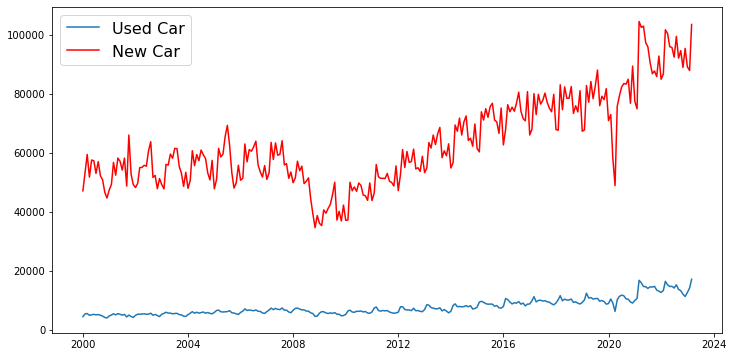

In [48]:
plt.figure(figsize=(12,6))
usedcar, = plt.plot(merged_df['used_sales'])
newcar, = plt.plot(merged_df['new_sales'],color = 'red')

plt.legend(['Used Car','New Car'],fontsize=16)

In [49]:
# Normalized
avg = merged_df.mean()
dev = merged_df.std()

for col in merged_df:
    merged_df[col] = (merged_df[col]-avg.loc[col]) / dev.loc[col]

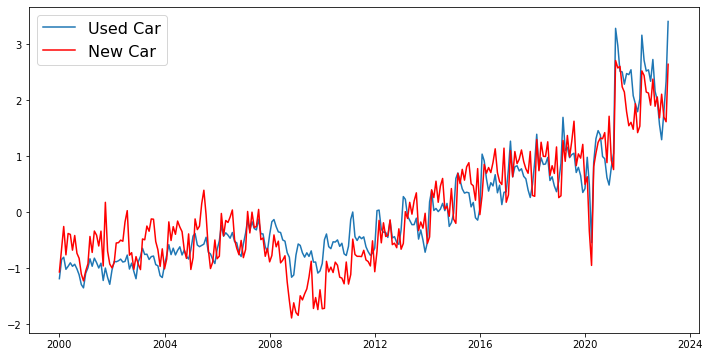

In [50]:
plt.figure(figsize=(12,6))
usedcar, = plt.plot(merged_df['used_sales'])
newcar, = plt.plot(merged_df['new_sales'],color = 'red')

plt.legend(['Used Car','New Car'],fontsize=16)

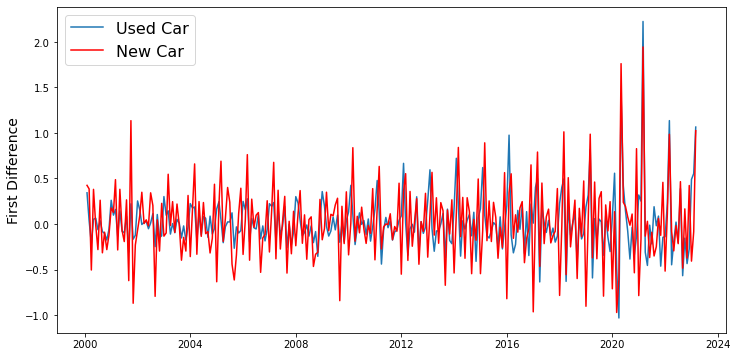

In [51]:
# Remove Trend
merged_df = merged_df.diff().dropna()

plt.figure(figsize=(12,6))
usedcar, = plt.plot(merged_df['used_sales'])
newcar, = plt.plot(merged_df['new_sales'],color = 'red')

plt.ylabel('First Difference',fontsize = 14)
plt.legend(['Used Car','New Car'],fontsize=16)

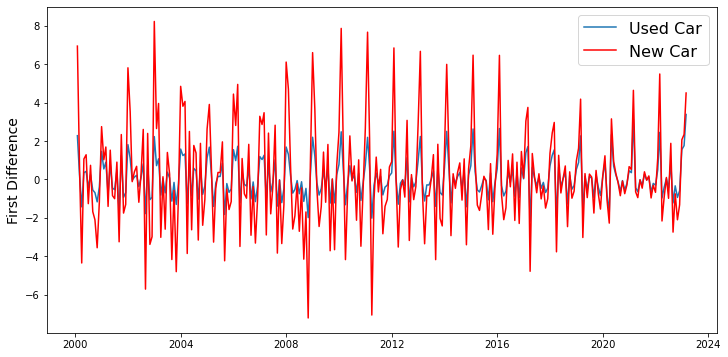

In [52]:
# Remove Volatility
vol = merged_df.groupby(merged_df.index.year).std()

merged_df['used_vol'] = merged_df.index.map(lambda d: vol.loc[d.year, 'used_sales'])
merged_df['new_vol'] = merged_df.index.map(lambda d: vol.loc[d.year, 'new_sales'])

merged_df['used_sales'] = merged_df['used_sales']/merged_df['used_vol']
merged_df['new_sales'] = merged_df['used_sales']/merged_df['new_vol']

plt.figure(figsize=(12,6))
usedcar, = plt.plot(merged_df['used_sales'])
newcar, = plt.plot(merged_df['new_sales'],color = 'red')

plt.ylabel('First Difference',fontsize = 14)
plt.legend(['Used Car','New Car'],fontsize=16)

In [53]:
# Correlation Between used_sales and lagged new_sales

for lag in range(1, 14):
    used_series = merged_df['used_sales'].iloc[lag:]
    lag_new_series = merged_df['new_sales'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(used_series, lag_new_series))
    print('------')

Lag: 1
(0.02036401946310159, 0.7357948853385288)
------
Lag: 2
(-0.11274792801215044, 0.06140373753338515)
------
Lag: 3
(-0.22085532257764093, 0.0002229572011590052)
------
Lag: 4
(-0.1918243281434636, 0.0014206566350359506)
------
Lag: 5
(0.08192878992915706, 0.17709791991484783)
------
Lag: 6
(-0.04758568590487827, 0.4344309563088724)
------
Lag: 7
(0.08276896539221089, 0.17427872427579227)
------
Lag: 8
(-0.17915548698119155, 0.0031357771680176377)
------
Lag: 9
(-0.22120107552481338, 0.0002557122334345073)
------
Lag: 10
(-0.11388882322824087, 0.06263303053610983)
------
Lag: 11
(0.06108518694920016, 0.3200349555882057)
------
Lag: 12
(0.750297050095705, 2.3169268979656962e-49)
------
Lag: 13
(0.04922337098679296, 0.42487376813361327)
------


**Comment:**  
We can see that the lagged 3,4,8,9 new_sales are correlated with the used_sales variable, we will now fit a VAR model.

In [54]:
# Fit a VAR Model

var_df = merged_df[['used_sales','new_sales']]
model = VAR(var_df)
mod_fit = model.fit(maxlags = 13)
mod_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, May, 2023
Time:                     12:49:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.957897
Nobs:                     265.000    HQIC:                  -1.39427
Log likelihood:          -474.463    FPE:                   0.185272
AIC:                     -1.68735    Det(Omega_mle):        0.152593
--------------------------------------------------------------------
Results for equation used_sales
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.083279         0.042125            1.977           0.048
L1.used_sales         -0.058245         0.175491           -0.332           0.740
L1.new_sales          -0.063791         0.069070   

**Comment:**  
We can conclude that the final VAR model should be like:$$\hat{UsedSales} = 0.083-0.36UsedSales_{t-2}-0.44UsedSales_{t-4}-0.14NewSales_{h-10}+0.14NewSales_{h-12}$$

### (m) Granger-Causality Test 

In [55]:
# Perform Granger-Causality test
max_lag = 13  # Maximum lag order
test_results = grangercausalitytests(var_df, maxlag=max_lag)

# Interpret the results
for lag in range(1, max_lag+1):
    print(f'Granger-Causality test (lag={lag}):')
    result = test_results[lag][0]
    p_value = result['ssr_chi2test'][1]
    if p_value < 0.05:
        print(f'  There is evidence of Granger causality (p-value={p_value:.4f})')
    else:
        print(f'  No significant evidence of Granger causality (p-value={p_value:.4f})')
    print()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3564  , p=0.5510  , df_denom=274, df_num=1
ssr based chi2 test:   chi2=0.3603  , p=0.5483  , df=1
likelihood ratio test: chi2=0.3601  , p=0.5485  , df=1
parameter F test:         F=0.3564  , p=0.5510  , df_denom=274, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5864  , p=0.5570  , df_denom=271, df_num=2
ssr based chi2 test:   chi2=1.1945  , p=0.5503  , df=2
likelihood ratio test: chi2=1.1919  , p=0.5510  , df=2
parameter F test:         F=0.5864  , p=0.5570  , df_denom=271, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4806  , p=0.6960  , df_denom=268, df_num=3
ssr based chi2 test:   chi2=1.4796  , p=0.6870  , df=3
likelihood ratio test: chi2=1.4756  , p=0.6879  , df=3
parameter F test:         F=0.4806  , p=0.6960  , df_denom=268, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3157  , p=0.8674  

### (n) VAR forecast

In [56]:
# Forecast 12 steps ahead
forecast = mod_fit.forecast(mod_fit.endog, steps=12)
# Access forecasted values for 'used_sales' and 'new_sales'
forecast_used_sales = forecast[:, 0]
forecast_new_sales = forecast[:, 1]

# Print forecasted values
print("Forecasted Used Sales:", forecast_used_sales)
print("Forecasted New Sales:", forecast_new_sales)

Forecasted Used Sales: [-1.0810029  -1.25313128 -0.59587299 -1.06354186  0.62669419 -0.82064382
  0.16182322 -0.18401277 -0.0127955   1.52753774  0.93375804  1.76706415]
Forecasted New Sales: [-2.80829569 -2.36945708 -0.54753295 -1.60421612  1.77925968 -1.29203933
  0.59118696  0.17645091  0.51451043  3.53249022  2.11247846  3.13213018]


In [57]:
# Calculate confidence intervals for the forecasted values
alpha = 0.05  # significance level
forecast_ci = mod_fit.forecast_interval(mod_fit.endog[-mod_fit.k_ar:], steps=12, alpha=alpha)

# Access confidence intervals for 'used_sales' and 'new_sales'
ci_lower_used_sales = forecast_ci[1][:, 0]
ci_upper_used_sales = forecast_ci[2][:, 0]
ci_lower_new_sales = forecast_ci[1][:, 1]
ci_upper_new_sales = forecast_ci[2][:, 1]

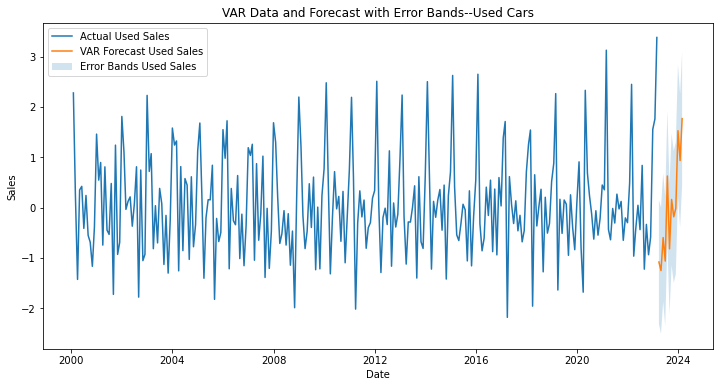

In [58]:
# Used Cars
# Plot forecast with error bands
plt.figure(figsize=(12, 6))
plt.plot(merged_df['used_sales'], label='Actual Used Sales')
forecast_dates = pd.date_range(start=merged_df.index[-1] + pd.DateOffset(days=1), periods=12, freq='M')
plt.plot(forecast_dates, forecast_used_sales, label='VAR Forecast Used Sales')
plt.fill_between(forecast_dates,
                 ci_lower_used_sales,
                 ci_upper_used_sales,
                 alpha=0.2, label='Error Bands Used Sales')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('VAR Data and Forecast with Error Bands--Used Cars')
plt.show()

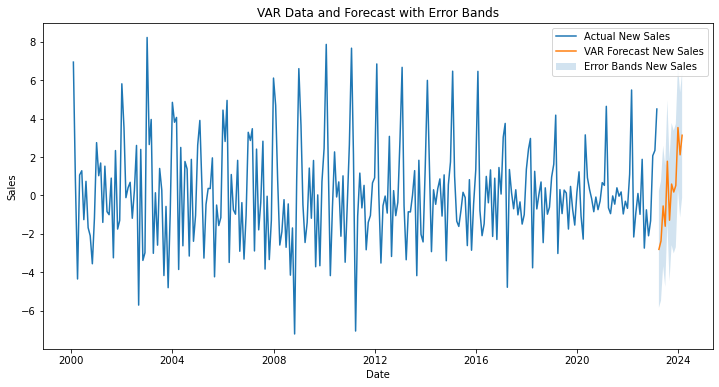

In [59]:
# New Cars
# Plot forecast with error bands
plt.figure(figsize=(12, 6))
plt.plot(merged_df['new_sales'], label='Actual New Sales')
plt.plot(forecast_dates, forecast_new_sales, label='VAR Forecast New Sales')
plt.fill_between(forecast_dates,
                 ci_lower_new_sales,
                 ci_upper_new_sales,
                 alpha=0.2, label='Error Bands New Sales')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('VAR Data and Forecast with Error Bands')
plt.show()

When compared with the models in part (i) and (j), we can see that VAR model predictions are more accurate. This is because VAR models capture the interdependencies among multiple variables, while the other models typically focus on forecasting a single variable. This difference allows VAR models to incorporate the dynamic relationships between variables. When there are poential correlations or dependencies between variables, VAR models will generate more accurate predictions.

### (o) FEVD Plot

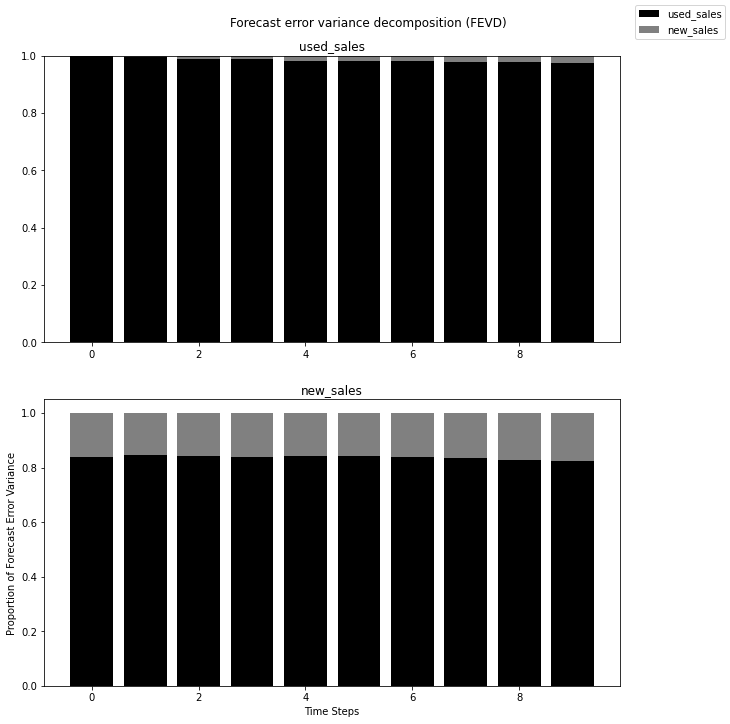

In [60]:
# Compute the FEVD
fevd = mod_fit.fevd()

# Plot the FEVD
fevd.plot()

# Set the plot labels and title
plt.xlabel('Time Steps')
plt.ylabel('Proportion of Forecast Error Variance')

# Show the plot
plt.show()

From the FEVD plot above, we can see that the used car sales is the dominant contributor to the forecast error variance for all time steps.The proportion of forecast error variance does not change much between different time steps, but there is a slightly decrease in used cars sales proportion of forecast error variance as time steps increases.

## Conclusion and Future Work

To evaluate the performance of the models, several metrics were used, including MAE，MSE，RMSE and MAPE values. We eventually concluded that for used car, ETS model and Holt-Winters model are euqally the best models since they have the lowest MAPE. For new car, OLS model is the best one since it has the lowest MAPE. However, the performance varied depending on the time period and the availability of data. 

While the current analysis provided valuable insights into the time series data of new and used car sales, there are several avenues for future work:

1. Feature Engineering: Explore additional features that may impact car sales, such as economic indicators, consumer sentiment, or interest rates. Incorporating these variables into the models may enhance their predictive capabilities.

2. Advanced Models: Investigate the performance of more advanced models, such as seasonal ARIMA (SARIMA), dynamic regression models, or machine learning algorithms like random forests or neural networks. These models may

3. Outliers and Anomalies: Identify and handle outliers or anomalies in the sales data that may affect the performance of the models. Outliers can distort the patterns and trends captured by the models, leading to inaccurate forecasts. Implement appropriate outlier detection and treatment techniques to improve model performance.

4. Model Validation: Validate the models using a holdout dataset or cross-validation techniques to assess their generalization performance. This step is crucial to ensure that the models can effectively forecast car sales in unseen future periods.

5. Model Interpretation: Explore methods to interpret the results of the models and extract actionable insights. Understanding the underlying drivers of car sales and the impact of different variables can help in making informed business decisions and strategies.

6. Model Updating and Monitoring: Establish a system to periodically update and retrain the models as new data becomes available. Regularly monitoring the model performance and recalibrating the models when necessary will ensure their continued relevance and accuracy over time.

7. Additional Data Sources: Consider incorporating additional data sources, such as demographic information, competitor sales, marketing campaigns, or industry reports, to enrich the analysis. These external factors may provide valuable context and contribute to more accurate forecasts.

8. Segmentation Analysis: Perform a segmentation analysis to identify different market segments within the new and used car sales data. Analyzing each segment separately can provide deeper insights into specific customer preferences, regional variations, or vehicle types, leading to more targeted forecasting and decision-making.

9. Causal Relationship Analysis: Explore causal relationships between car sales and other economic or social factors using techniques such as Granger causality or regression analysis. Understanding the causal drivers of car sales can help in developing proactive strategies and interventions.

## IV. References

### Data Sources:
U.S. Census Bureau, Retail Sales: New Car Dealers [MRTSSM44111USN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MRTSSM44111USN, May 19, 2023

U.S. Census Bureau, Retail Sales: Used Car Dealers [MRTSSM44112USN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MRTSSM44112USN, May 19, 2023.